# Single-molecule experiment prediction model

This notebook is the step by step development process for making a SNN to predict the reactivity level and number of reactions in Single-molecule experiments
Data is provided via the Kent State University chemistry department. The model development is provided by the Kent State University computer science department

<table style="border:none;padding: 10px;margin: auto;">
    <tr style="border:none;padding: 10px;margin: auto;">
        <td style="border:none;padding: 10px;margin: auto;">
            <b>Contacts from the chem dept.</b><br>
            Li Zuo <br>
            Email: lzuo4@kent.edu <br>
            Office: 303B Willems Hall (ISB) <br>
            <br>
            Dr. Hao Shen<br>
            Email: hshen7@kent.edu<br>
        </td>
        <td style="border:none;padding: 10px;margin: auto;">
            <b>Contacts from the CS dept.</b><br>
            Kendric Hood<br>
            Email: khood5@kent.edu<br>
            Office: 160 Math and Science Building (MSB)<br>
            <br>
            Dr. Qiang Guan <br>
            Email: qguan@kent.edu<br>
        </td>
    </tr>
</table>






Working with data from <code>Prepocessing/data/spikeTrains</code> should have folder for each experment setup (in terms of disctance of magnent in mm). Each folder should have a list of spike trains as csv files. Spike trains are recorded as events per 0.05 secs. The index file has the list of each spike train path and the class they are in. Classes are configureable via the preprocessing but should be somthing like this 

<table style="border:none;padding: 10px;margin: auto;">
    <tr style="border:none;padding: 10px;margin: auto;">
        <td style="border:none;padding: 10px;margin: auto;">
        9/5mm
        <table>
            <th>Class</th><th>Number of reactions</th>
            <tr> <td>High</td> <td>>300</td> </tr>
            <tr> <td>Medium</td> <td>300-230</td> </tr>
            <tr> <td>Low</td> <td>&lt;230</td> </tr>
        </table>
        </td>
        <td style="border:none;padding: 10px;margin: auto;">
        3mm
        <table>
            <th>Class</th><th>Number of reactions</th>
            <tr> <td>High</td> <td>>150</td> </tr>
            <tr> <td>Medium</td> <td>100-150</td> </tr>
            <tr> <td>Low</td> <td>&lt;100</td> </tr>
        </table>
        </td>
        <td style="border:none;padding: 10px;margin: auto;">
        2/1.5mm
        <table>
            <th>Class</th><th>Number of reactions</th>
            <tr> <td>High</td> <td>>50</td> </tr>
            <tr> <td>Medium</td> <td>30-50</td> </tr>
            <tr> <td>Low</td> <td>&lt;30</td> </tr>
        </table>
        </td>
    </tr>
</table>

We are using Intel's lava-nc framework https://lava-nc.org

In [1]:
%reset
# progress_bar for when stuff takes a while to load
def progress_bar(current, total, bar_length=20):
    fraction = current / total

    arrow = int(fraction * bar_length - 1) * '-' + '>'
    padding = int(bar_length - len(arrow)) * ' '

    ending = '\n' if current == total else '\r'

    print(f'Progress: [{arrow}{padding}] {int(fraction*100)}%', end=ending)

----
#### DataLoader

This is our data loader. Should get an index file for an experment type (9mm,5mm etc). The index file should contain a path to each indiviual training experiment and the class it belongs to high, medium, or low.
Note that the class is represented as a int, the map is shown below

|class         | numerical value|
|--------------|----------------|
|<i>high</i>   |               2|
|<i>medium</i> |               1|
|<i>low</i>    |               0|

Example index file (Prepocessing/data/spikeTrains/1.5-SpikeTrains/index.csv)
<pre>
spikeTrain_1.csv,0
spikeTrain_2.csv,0
spikeTrain_3.csv,1
spikeTrain_4.csv,0
spikeTrain_5.csv,2
spikeTrain_6.csv,1
</pre>


Example spik train file (Prepocessing/data/spikeTrains/1.5-SpikeTrains/spikeTrain_1.csv)
<pre>
0
0
0
.
.
.
0
0
1
0
.
.
.
</pre>

In [2]:
import numpy as np
import pandas as pd
import os

class expermentDataloader:
    def __init__(
        self,
        index_file: str, 
        data_path: str,
    ):
        self.root_dir = data_path
        self.expermentSikeTrainsIndex = pd.read_csv(index_file) # self.landmarks_frame = pd.read_csv(csv_file)
        self.spikeTrains = [
            f"{os.path.join(self.expermentSikeTrainsIndex.iloc[i, 0])}" for i in range(len(self.expermentSikeTrainsIndex)) 
        ]
        self.expermentClasses = self.expermentSikeTrainsIndex.iloc[:, 1]

    def __getitem__(self, index):
        CSVlines = pd.read_csv(os.path.join(self.root_dir,self.spikeTrains[index])).to_numpy()
        eventClass = self.expermentClasses[index]
        return np.array(list(CSVlines.flatten())), int(eventClass)

    def __len__(self):
        return len(self.expermentSikeTrainsIndex)

In [3]:
indexFile5mm = "./Prepocessing/data/spikeTrains/5-SpikeTrains/index.csv"
PathTo5mmSpikeTrains = "./Prepocessing/data/spikeTrains/5-SpikeTrains"

trainingData = expermentDataloader(indexFile5mm,PathTo5mmSpikeTrains)

print(f"Is NOT all zeros: {np.any(trainingData[0][0])}")
print(len(trainingData[0][0]))
print(f"Number of spikes: {sum(trainingData[0][0])}")
trainingData[0]


Is NOT all zeros: True
2999
Number of spikes: 5


(array([0, 0, 0, ..., 0, 0, 0]), 0)

In [4]:
print(f"Is NOT all zeros: {np.any(trainingData[1][0])}")
print(len(trainingData[1][0]))
print(f"Number of spikes: {sum(trainingData[1][0])}")
trainingData[1]

Is NOT all zeros: True
2999
Number of spikes: 32


(array([0, 0, 0, ..., 0, 0, 0]), 1)

In [5]:
print(f"Is NOT all zeros: {np.any(trainingData[len(trainingData)-1][0])}")
print(len(trainingData[len(trainingData)-1][0]))
print(f"Number of spikes: {sum(trainingData[len(trainingData)-1][0])}")
trainingData[len(trainingData)-1]

Is NOT all zeros: True
2999
Number of spikes: 51


(array([0, 0, 0, ..., 0, 0, 0]), 2)

----
#### Spike Input Process

Our input processes should read spike trains from the data loader and just feed them into lava-nc models

In [6]:
# general imports
import typing as ty

# Import premade Processes
from lava.proc.dense.process import Dense
from lava.proc.lif.process import LIF

# Import Processes and Process level primitives
from lava.magma.core.process.process import AbstractProcess
from lava.magma.core.process.variable import Var
from lava.magma.core.process.ports.ports import  OutPort, InPort

# Import ProcessModels and ProcessModels level primitives
from lava.magma.core.decorator import implements, requires
from lava.magma.core.model.py.model import PyLoihiProcessModel
from lava.magma.core.model.py.ports import PyOutPort, PyInPort
from lava.magma.core.model.py.type import LavaPyType
from lava.magma.core.resources import CPU

# Import execution protocol and hardware resources
from lava.magma.core.sync.protocols.loihi_protocol import LoihiProtocol
from lava.magma.core.run_configs import Loihi1SimCfg
from lava.magma.core.run_conditions import RunSteps, RunContinuous

# Import Monitor and graph stuff
from lava.proc.monitor.process import Monitor
import matplotlib
%matplotlib inline
from matplotlib import pyplot as plt

We are using the LoihiProtocol defined in detail <a href="https://lava-nc.org/lava/lava.magma.core.sync.protocols.html#lava.magma.core.sync.protocols.loihi_protocol.LoihiProtocol">here</a> 
It operats in phases as follows
1. Spiking phase (run_spk): 
      <br>Guards: <code>None</code>

2. Pre management phase (run_pre_mgmt):
      <br>Guards: <code>pre_guard()</code> and <code>learn_guard()</code>

3. Learning phase (run_lrn): 
      <br>Guards: <code>learn_guard()</code> 

4. Post management phase (run_post_mgmt): 
      <br>Guards: <code>post_guard</code> and <code>learn_guard()</code> 

5. Host phase (run_host_mgmt): 
      <br>Guards: <code>host_guard()</code>

If a guard is undefined then it's guarded method always runs. If the method it's self is undefined then nothing runs

After testing a bit it looks like some of the guards run multiple times 
see the captured output from simply printing the functions name after 3 iterations 
<pre>
run_spk
lrn_guard
pre_guard
pre_guard
run_pre_mgmt
post_guard
run_post_mgmt
lrn_guard
run_lrn
post_guard
post_guard
run_post_mgmt
---repeats---
</pre>
Could be multi-threaded?

System time (i.e. the self.time_step) starts from <code>1</code> not <code>0</code>

In [71]:
np.set_printoptions(linewidth=np.inf)

class SpikeInput(AbstractProcess):
    def __init__(self,
                 num_spike_trains: ty.Optional[int], # no defulte depends on input experment setting (i.e. 5mm, 3mm etc)
                 spike_train_length: ty.Optional[int], # Number of steps recorded every 0.05 secs
                 output_shape = (3,)
                 ):
        super().__init__()
        self.spikes_out = OutPort(shape=output_shape)  # Input spikes to the classifier
        self.label_out = OutPort(shape=(1,))  # Ground truth labels to OutputProc
        self.num_spike_trains = Var(shape=(1,), init=num_spike_trains)
        self.spike_train_length = Var(shape=(1,), init=spike_train_length)
        self.input_spike_train = Var(shape=(spike_train_length,), init=trainingData[0][0])
        self.ground_truth_label = Var(shape=(1,), init=trainingData[0][1])
        
@implements(proc=SpikeInput, protocol=LoihiProtocol)
@requires(CPU)
class PySpikeInputModel(PyLoihiProcessModel):
    # num_images: int = LavaPyType(int, int, precision=32)
    num_spike_trains: int = LavaPyType(int, int, precision=32)
    
    spikes_out: PyOutPort = LavaPyType(PyOutPort.VEC_DENSE, bool, precision=1)
    label_out: PyOutPort = LavaPyType(PyOutPort.VEC_DENSE, np.int32,
                                      precision=32)
    
    # num_steps_per_image: int = LavaPyType(int, int, precision=32)
    spike_train_length: int = LavaPyType(int, int, precision=32)
    
    # input_img: np.ndarray = LavaPyType(np.ndarray, int, precision=32)
    input_spike_train: np.ndarray = LavaPyType(np.ndarray, int, precision=32)
    
    ground_truth_label: int = LavaPyType(int, int, precision=32)
    
    def __init__(self, proc_params):
        super().__init__(proc_params=proc_params)
        self.curr_spike_train_id = 0
        

    def run_spk(self):
        """Spiking phase: executed unconditionally at every time-step
        """
        spike, self.input_spike_train = self.input_spike_train[0], self.input_spike_train[1:]
        output = np.zeros(self.spikes_out.shape)
        output += spike
        
        if len(self.input_spike_train) == 0:
            # when done with one spike train move to next one
            self.curr_spike_train_id += 1
            self.ground_truth_label = trainingData[self.curr_spike_train_id][1]
            self.input_spike_train = trainingData[self.curr_spike_train_id][0].astype(np.int32)
        
        self.spikes_out.send(output)

In [72]:
steps_per_spike_train = 2999
number_of_spike_trains = 3
spike_input = SpikeInput(num_spike_trains=len(trainingData)-1, spike_train_length=steps_per_spike_train)

monitor_input = Monitor()
monitor_input.probe(spike_input.spikes_out, steps_per_spike_train*number_of_spike_trains)


In [73]:
print(f"ground_truth_labels in order: ", end="")
for i in range(number_of_spike_trains):
    print(f"{trainingData[i][1]},", end="")
print()

for i in range(number_of_spike_trains):
    print(f"Running Spike Train {i}, class {int(spike_input.ground_truth_label.get())}")
    run_cfg = Loihi1SimCfg(select_tag="floating_pt")
    run_condition = RunSteps(num_steps=steps_per_spike_train)
    spike_input.run(condition=run_condition, run_cfg=run_cfg)
    

ground_truth_labels in order: 0,1,0,
Running Spike Train 0, class 0
Running Spike Train 1, class 1
Running Spike Train 2, class 0


We should see 6 dots come out of this, means we ran for the right length of time (one dot means 500 simulated time steps). and below we should see a chart that shows the spikes coming out of the input neuron. 

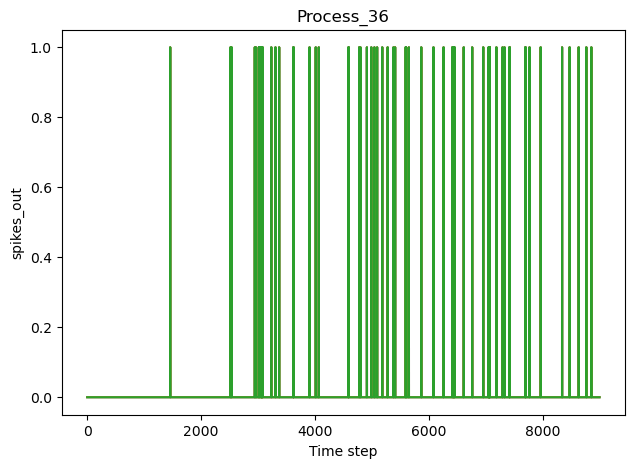

In [74]:
# Create a subplot for each monitor
fig = plt.figure(figsize=(16, 5))
ax0 = fig.add_subplot(121)

# Plot the recorded data
monitor_input.plot(ax0, spike_input.spikes_out)

In [ ]:
spike_input.stop()

----
#### Making SNN

Now we take our spike input process and connect it to the rest of our network. We will build a simple 2 LIF layer network. Each layer will be fully connected (i.e. dense). 
The SpikeInput Generator take an output shape as an argument. This will allow us to control how many LIF neurons are in the next layer. The spikes from the input spike train are sent to all LIF nuerons innthe next layer. 

In [185]:
# Create processes
# SpikeInput(num_spike_trains=len(trainingData)-1, spike_train_length=steps_per_spike_train)
spike_input = SpikeInput(num_spike_trains=len(trainingData),        # Number of spikes per spike train
                         spike_train_length=steps_per_spike_train,  # 
                         output_shape=(3,))                         # output shape i.e. outputs to 3 nuerons (3,) 4 nuerons (4,) etc.

dense0 = Dense(weights=np.random.rand(3, 3),     # Initial value of the weights, chosen randomly
              name='dense')

lif1 = LIF(shape=(3, ),                         # Number and topological layout of units in the process
           vth=10.,                             # Membrane threshold
           dv=0.1,                              # Inverse membrane time-constant
           du=0.1,                              # Inverse synaptic time-constant
           bias_mant=(1.1, 1.2, 1.3),           # Bias added to the membrane voltage in every timestep
           name="lif1")

dense2 = Dense(weights=np.random.rand(2, 3),     # Initial value of the weights, chosen randomly
              name='dense')

lif3 = LIF(shape=(2, ),                         # Number and topological layout of units in the process
           vth=10.,                             # Membrane threshold
           dv=0.1,                              # Inverse membrane time-constant
           du=0.1,                              # Inverse synaptic time-constant
           bias_mant=0.,                        # Bias added to the membrane voltage in every timestep
           name='lif2')

In [186]:
spike_input.spikes_out.connect(dense0.s_in)
dense0.a_out.connect(lif1.a_in)
lif1.s_out.connect(dense2.s_in)
dense2.a_out.connect(lif3.a_in)

If either of the two above cell have <code>errors</code> here due to incompatable shapes remeber that Dense layers wight shape is (number of next layer nuerons, number of prevous layer nuerons), see below

<pre>
import numpy as np

# Create processes
lif1 = LIF(shape=(<code>X</code>, ), ... )

dense = Dense(weights=np.random.rand(<code>Y</code>, <code>X</code>),     # Initial value of the weights, chosen randomly
              name='dense')

lif2 = LIF(shape=(<code>Y</code>, ....), 
</pre>

In [187]:
num_steps = 3000

monitor_input = Monitor()
monitor_output = Monitor()
monitor_input.probe(spike_input.spikes_out, num_steps)
monitor_output.probe(lif3.s_out, num_steps)


In [188]:
run_condition = RunContinuous()
run_condition = RunSteps(num_steps=num_steps)
run_cfg = Loihi1SimCfg(select_tag="floating_pt")
lif3.run(condition=run_condition, run_cfg=run_cfg)

Now we graph the input and output for comparison, we should see some spikes come out.

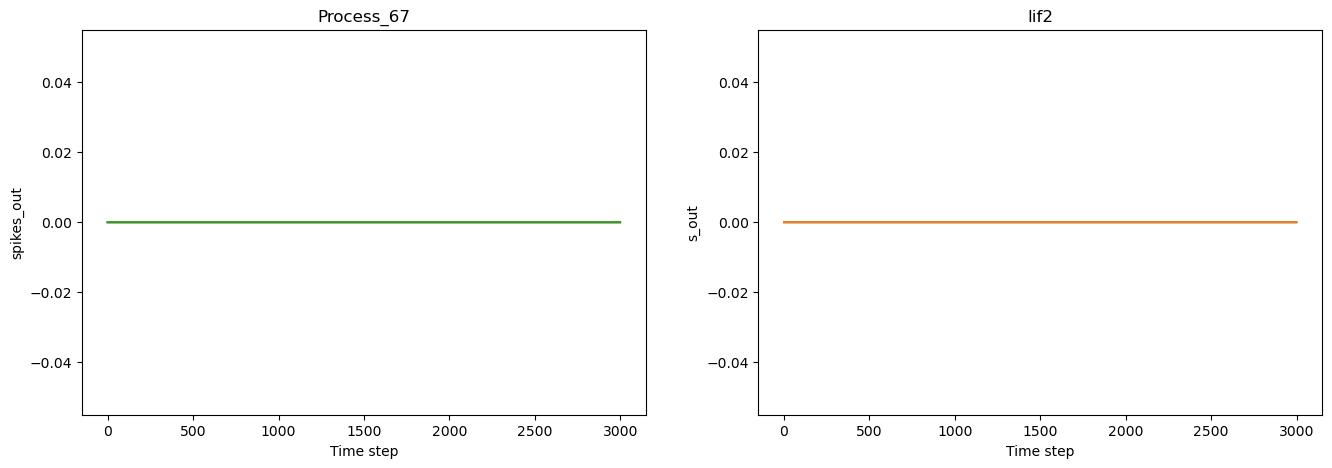

In [189]:
# Create a subplot for each monitor
fig = plt.figure(figsize=(16, 5))
ax0 = fig.add_subplot(121)
ax1 = fig.add_subplot(122)

# Plot the recorded data
monitor_input.plot(ax0, spike_input.spikes_out)
monitor_output.plot(ax1, lif3.s_out)

> **Note**:
>
> The graph on the right will not be consistant sense we are using random weights and nothing is being trained, each time we run it we will get diffrent spikes, but we should always see some spikes. i.e. the graph on the right should never be flat, but will change after each run

In [245]:
lif3.stop()

----
#### Classification Process

Now that we have out SpikeInput process to read the spike trains, and we have our SNN model we need to make a classifer to take the output of the SNN and map it to a class. As a reminder we have the following setup

<p><center><code>Raw data classification based on reactions per experment</code></center></p>
<table style="border:none;padding: 10px;margin: auto;">
    <tr style="border:none;padding: 10px;margin: auto;">
        <td style="border:none;padding: 10px;margin: auto;">
        9/5mm
        <table>
            <th>Class</th><th>Number of reactions</th>
            <tr> <td>High</td> <td>>300</td> </tr>
            <tr> <td>Medium</td> <td>300-230</td> </tr>
            <tr> <td>Low</td> <td>&lt;230</td> </tr>
        </table>
        </td>
        <td style="border:none;padding: 10px;margin: auto;">
        3mm
        <table>
            <th>Class</th><th>Number of reactions</th>
            <tr> <td>High</td> <td>>150</td> </tr>
            <tr> <td>Medium</td> <td>100-150</td> </tr>
            <tr> <td>Low</td> <td>&lt;100</td> </tr>
        </table>
        </td>
        <td style="border:none;padding: 10px;margin: auto;">
        2/1.5mm
        <table>
            <th>Class</th><th>Number of reactions</th>
            <tr> <td>High</td> <td>>50</td> </tr>
            <tr> <td>Medium</td> <td>30-50</td> </tr>
            <tr> <td>Low</td> <td>&lt;30</td> </tr>
        </table>
        </td>
    </tr>
</table>
<br>
<br>
<center>
<code>Class mapping for our data loader</code>
<br><br><br>

|Class         | Numerical value <br>given by dataloader|
|--------------|----------------|
|<i>high</i>   |               2|
|<i>medium</i> |               1|
|<i>low</i>    |               0|
</center>

Out ClassificationProcess will connected to the laster layer. The last layer should have 3 neurons (one for each class). The ClassificationProcess counts the number of spikes generated from each of the final 3 neurons. The neuron with the most spikes (i.e. the highest activation value) correlates to the predicted class. 

In [246]:
NUM_CLASSES = 3

class ClassificationProcess(AbstractProcess):
    """Process to gather spikes from output of LIF neurons and interpret the
    highest spiking rate as the classifier output. There should be 3 LIF neurons (one for each class)"""

    def __init__(self,
                 num_spike_trains: ty.Optional[int], # no defulte depends on input experment setting (i.e. 5mm, 3mm etc)
                 spike_train_length: ty.Optional[int] = 3000, # Number of steps recorded every 0.05 secs
                 output_shape = (NUM_CLASSES,)
                 ):
        super().__init__()
        n_spike_trains = num_spike_trains
        self.num_spike_trains = Var(shape=(1,), init=n_spike_trains)
        self.spikes_in = InPort(shape=output_shape)
        self.label_in = InPort(shape=(1,))
        self.spikes_accum = Var(shape=output_shape)  # Accumulated spikes for classification
        self.num_steps_per_spike_train = Var(shape=(1,), init=spike_train_length)
        self.pred_labels = Var(shape=(n_spike_trains,))
        self.gt_labels = Var(shape=(n_spike_trains,))
        
@implements(proc=ClassificationProcess, protocol=LoihiProtocol)
@requires(CPU)
class PyClassificationProcessModel(PyLoihiProcessModel):
    label_in: PyInPort = LavaPyType(PyInPort.VEC_DENSE, int, precision=32)
    spikes_in: PyInPort = LavaPyType(PyInPort.VEC_DENSE, bool, precision=1)
    num_spike_trains: int = LavaPyType(int, int, precision=32)
    spikes_accum: np.ndarray = LavaPyType(np.ndarray, np.int32, precision=32)
    num_steps_per_spike_train: int = LavaPyType(int, int, precision=32)
    pred_labels: np.ndarray = LavaPyType(np.ndarray, int, precision=32)
    gt_labels: np.ndarray = LavaPyType(np.ndarray, int, precision=32)
        
    def __init__(self, proc_params):
        super().__init__(proc_params=proc_params)
        self.curr_spike_train_id = 0

    def post_guard(self):
        """Guard function for PostManagement phase.
        """
        if self.time_step % self.num_steps_per_spike_train == 0 and \
                self.time_step > 1:
            return True
        return False

    def run_post_mgmt(self):
        """Post-Management phase: executed only when guard function above 
        returns True.
        """
        gt_label = self.label_in.recv()
        pred_label = np.argmax(self.spikes_accum)
        self.gt_labels[self.curr_spike_train_id] = gt_label
        self.pred_labels[self.curr_spike_train_id] = pred_label
        self.curr_spike_train_id += 1
        self.spikes_accum = np.zeros_like(self.spikes_accum)

    def run_spk(self):
        """Spiking phase: executed unconditionally at every time-step
        """
        spk_in = self.spikes_in.recv()
        self.spikes_accum = self.spikes_accum + spk_in

Now we build our SNN but with our ClassificationProcess connected. We connect it to the last layer and the first. The last layer output spike trains are what is used for the prediced class. There is a link between the first layer (SpikeInput) and the ClassificationProcess. This connection serves as a way for the ClassificationProcess to get the ground truth of the experment being run though the SNN. 

In [248]:
num_experments = 1
num_steps = 3000

# Create processes
spike_input = SpikeInput(num_spike_trains=len(trainingData),    # Number of spikes per spike train
                         output_shape=(3,))                     # output shape i.e. outputs to 3 nuerons (3,) 4 nuerons (4,) etc.

dense0 = Dense(weights=np.random.rand(3, 3),     # Initial value of the weights, chosen randomly
              name='dense')

lif1 = LIF(shape=(3, ),                         # Number and topological layout of units in the process
           vth=10.,                             # Membrane threshold
           dv=0.1,                              # Inverse membrane time-constant
           du=0.1,                              # Inverse synaptic time-constant
           bias_mant=(1.1, 1.2, 1.3),           # Bias added to the membrane voltage in every timestep
           name="lif1")

dense2 = Dense(weights=np.random.rand(3, 3),     # Initial value of the weights, chosen randomly
              name='dense')

lif3 = LIF(shape=(3, ),                         # Number and topological layout of units in the process
           vth=10.,                             # Membrane threshold
           dv=0.1,                              # Inverse membrane time-constant
           du=0.1,                              # Inverse synaptic time-constant
           bias_mant=0.,                        # Bias added to the membrane voltage in every timestep
           name='lif2')

dense4 = Dense(weights=np.random.rand(3, 3),     # Initial value of the weights, chosen randomly
              name='dense')

classifier = ClassificationProcess(num_spike_trains=num_experments)


spike_input.spikes_out.connect(dense0.s_in)
dense0.a_out.connect(lif1.a_in)
lif1.s_out.connect(dense2.s_in)
dense2.a_out.connect(lif3.a_in)
lif3.s_out.connect(dense4.s_in)
dense4.a_out.connect(classifier.spikes_in) # connecting to last layer
spike_input.label_out.connect(classifier.label_in) # connecting to ground turth from first layer

monitor_input = Monitor()
monitor_output = Monitor()

In [20]:
# lif1.u?

Now let calculate some accuracy

In [249]:
num_steps = 3000 
monitor_input.probe(spike_input.spikes_out, num_steps)
monitor_output.probe(lif3.s_out, num_steps)

# Loop over all experments
for experment_id in range(num_experments):
    print(f"\rCurrent experment: {experment_id+1}", end="")
    
    # Run each experment-inference for fixed number of steps
    classifier.run(
        condition=RunSteps(num_steps=num_steps),
        run_cfg=Loihi1SimCfg(select_sub_proc_model=True,
                             select_tag='floating_pt'))
    
    # Reset internal neural state of LIF neurons
    lif1.u.set(np.zeros((3,), dtype=np.int32))
    lif1.v.set(np.zeros((3,), dtype=np.int32))
    lif3.u.set(np.zeros((3,), dtype=np.int32))
    lif3.v.set(np.zeros((3,), dtype=np.int32))

# Gather ground truth and predictions before stopping exec
ground_truth = classifier.gt_labels.get().astype(np.int32)
predictions = classifier.pred_labels.get().astype(np.int32)

accuracy = np.sum(ground_truth==predictions)/ground_truth.size * 100

print(f"\nGround truth: {ground_truth}\n"
      f"Predictions : {predictions}\n"
      f"Accuracy    : {accuracy}")

Current experment: 1

/home/khood/anaconda3/envs/dna/lib/python3.10/site-packages/lava/magma/compiler/compiler_graphs.py:869: UserWarning: Cannot import module '<module '3076743886' from '/tmp/ipykernel_125473/3076743886.py'>' when searching ProcessModels for Process 'ClassificationProcess'.
  warnings.warn(


curr_spike_train_id: 0
self.input_spike_train: 2501
. curr_spike_train_id: 0
self.input_spike_train: 2001
. curr_spike_train_id: 0
self.input_spike_train: 1501
. curr_spike_train_id: 0
self.input_spike_train: 1001
. curr_spike_train_id: 0
self.input_spike_train: 501
. curr_spike_train_id: 0
self.input_spike_train: 1
. run_post_mgmt
run_post_mgmt>curr_spike_train_id: 1
run_post_mgmt>ground_truth_label: 0
run_post_mgmt>input_spike_train: [0 0 0 ... 0 0 0]
run_post_mgmt>self.input_spike_train: 2999

Ground truth: [0]
Predictions : [0]
Accuracy    : 100.0


We can graph the input and output layers to check and make sure everything is still working. We can skip this step if we are pretty sure things are working

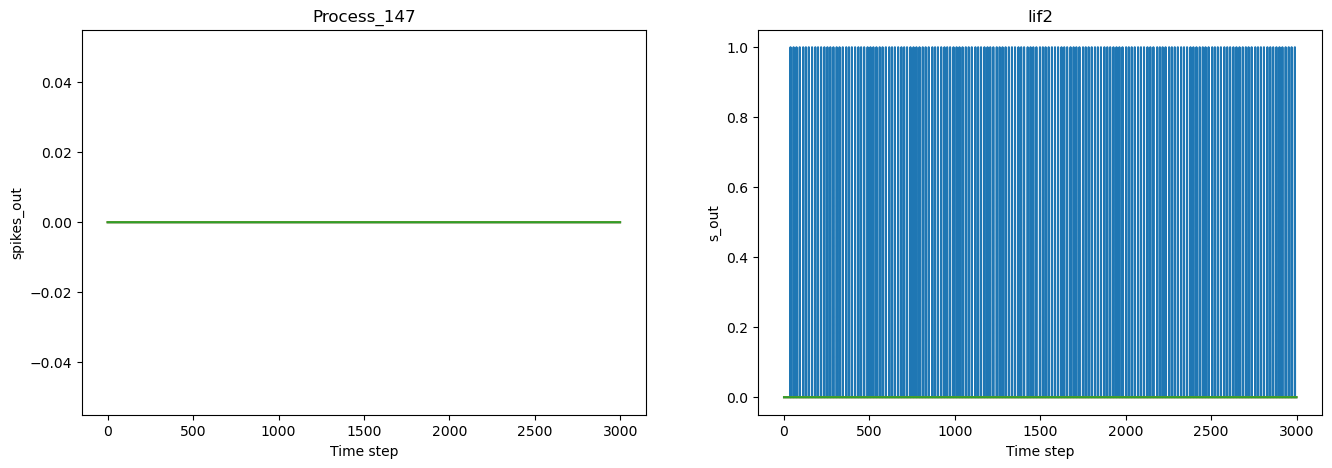

In [250]:
# Create a subplot for each monitor
fig = plt.figure(figsize=(16, 5))
ax0 = fig.add_subplot(121)
ax1 = fig.add_subplot(122)

# Plot the recorded data
monitor_input.plot(ax0, spike_input.spikes_out)
monitor_output.plot(ax1, lif3.s_out)

In [251]:
classifier.stop()